<div style="font-size: 32px; font-weight: bold; margin-top: 20px;">
  Tutorial on Kinetic Monte Carlo / Gillespie Simulation
</div>

# Necessary Packages and Background
Please run the following cell before running anything else. It will ensure that the notebook works properly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numba import njit, prange

## While Loops
In many applications, you know how many items you need to check in a container or how many times a function needs to be applied. For loops work great for this. However, there are some conditions where you want to stay in a loop until some condition is met or fails and you don't know how many iterations this will take. This is particularly important for Gillespie simulations. We want to run simulations for a certain amount of time, but we don't use some fixed time step. The reaction times are randomly sampled, so we don't know how many we need.

While loops are perfect for this. The user provides a conditional, and the code stays in the loop as long as the conditional is true. When it fails, the code exits the loop. First, note that a while loop can do anything a for loop can, though it may be a bit uglier:

In [2]:
my_list = [0, 1, 2, 3, 4, 5]

# For loop approach
print("Begin for loop printing")
for x in my_list:
    print(x)
    
# While loop approach
print("Begin while loop printing")
# Instead of looping directly over the elements of the list, we loop over the positions in the container.
index = 0
while index < len(my_list):
    print(my_list[index])
    index += 1

Begin for loop printing
0
1
2
3
4
5
Begin while loop printing
0
1
2
3
4
5


Now let's do something that a for loop can't do nicely. Let's randomly sample numbers between 0 and 1, add them up until the sum is greater than 5, and then print the number of terms we needed. Run the following code below a few times to see the number of times you repeat the loop is random.

In [3]:
threshold = 5
my_sum = 0
terms_needed = 0

while my_sum <= threshold:
    my_sum += np.random.rand()
    terms_needed += 1
    
print(terms_needed)

16


# Simple Birth-Death Reactions

Consider the following systems of reactions:  
Production: $ X \rightarrow X + 1 $ with rate $$ k $$  

Degradation: $ X \rightarrow X - 1 $ with rate $$ rX $$   

This is known as the simple birth-death process. It will be our starting point for learning Gillespie simulations. Let's start by writing a simulation that is kind of useless because it doesn't return anything, but we will see how the logic works.

## Basic Gillespie Simulation with No Output

In [4]:
# Set the parameters
simple_birth_death_k = 10
simple_birth_death_r = 1

# Set the initial state and time info
simple_birth_death_state = 0
time = 0
final_time = 100

# Run the loop
while time < final_time:
    # First, determine when the next reaction occurs
    # Since np.random.rand() returns a random x with 0 <= x < 1, we use 1 - x to avoid adding log(0).
    u = 1 - np.random.rand()
    rate_sum = simple_birth_death_k + simple_birth_death_r*simple_birth_death_state
    dt = -np.log(u)/rate_sum
    # Advance the simulation time
    time += dt
    # Next, we need to figure out which reaction occurs.
    rate_fraction = np.random.rand()*rate_sum
    # We order the reactions [birth, death] for no particular reason
    if rate_fraction <= simple_birth_death_k:
        # Perform a birth event
        simple_birth_death_state += 1
    else:
        # Perform a death event
        simple_birth_death_state -= 1

## Recording the State at Discrete Times for Plotting

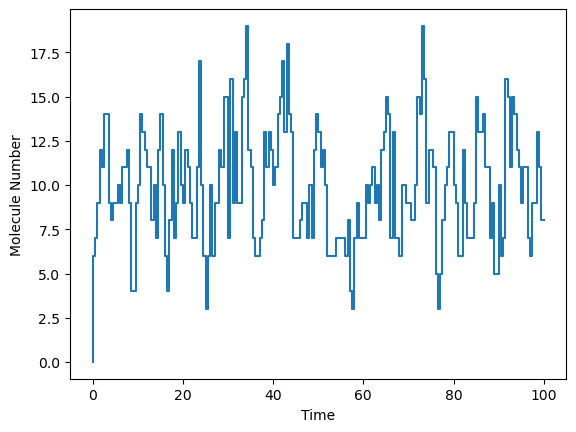

In [5]:
# Reset the parameters
simple_birth_death_k = 10
simple_birth_death_r = 1

# Reset the initial state and time info
simple_birth_death_state = 0
time = 0
final_time = 100

# Set the variables pertaining to recording states
time_between_snapshots = 0.5
snapshot_counter = 0
snapshot_time = snapshot_counter*time_between_snapshots
times = []
recorded_states = []

# Run the Gillespie simulation
while time < final_time:
    # First, determine when the next reaction occurs and advance the time
    u = 1 - np.random.rand()
    rate_sum = simple_birth_death_k + simple_birth_death_r*simple_birth_death_state
    dt = -np.log(u)/rate_sum
    time += dt
    # Recording: This is the main new part. Since dt is random, it may jump
    # over many snapshot times, so we need to use another while loop.
    while time >= snapshot_time and snapshot_time <= final_time:
        times.append(snapshot_time)
        recorded_states.append(simple_birth_death_state)
        snapshot_counter += 1
        snapshot_time = snapshot_counter*time_between_snapshots
    # Identify the reaction and update the state
    rate_fraction = np.random.rand()*rate_sum
    # We order the reactions [birth, death] for no particular reason
    if rate_fraction <= simple_birth_death_k:
        # Perform a birth event
        simple_birth_death_state += 1
    else:
        # Perform a death event
        simple_birth_death_state -= 1
    
# Plot the trajectory
plt.step(times, recorded_states)
plt.xlabel("Time")
plt.ylabel("Molecule Number");

## Computing Probabilities and Moments Using an Ensemble
The idea here is to now compute the probability distribution and some statistics of the final state. We will run a bunch of independent trajectories and then store the states at the final time.

There is a bit of a downside. The time to run the simulation increases with the number of trials we run. You can use the Numba library to pre-compile certain codes and enable parallelism. Different parts of your computer will run different simulations. Numba makes this fairly easy to use with @njit. You do not need to know or understand this, it is just meant to make the demo run faster.

In [6]:
@njit
def get_final_state_from_single_birth_death_trial(k, r, initial_state, final_time):
    # Set the state and time 
    state = initial_state
    time = 0
    # The contents of this loop are exactly the same as the first one we did.
    while time < final_time:
        # First, determine when the next reaction occurs and advance the time
        u = 1 - np.random.rand()
        rate_sum = k + r*state
        dt = -np.log(u)/rate_sum
        time += dt
        # Identify the reaction and update the state. We use a conditional because we care about the state at a particular time
        if time <= final_time:
            rate_fraction = np.random.rand()*rate_sum
            # We order the reactions [birth, death] for no particular reason
            if rate_fraction <= k:
                # Perform a birth event
                state += 1
            else:
                # Perform a death event
                state -= 1
    # Return the state at the end
    return state

@njit(parallel=True)
def get_final_states_from_many_birth_death_trials(num_trials, k, r, initial_state, final_time):
    # Create a container for our results
    results = []
    # prange tells the computer to do a number of parallel jobs equal to the value of num_trials
    for i in prange(num_trials):
        # Run each simulation and stick it in the list
        results.append(get_final_state_from_single_birth_death_trial(k, r, initial_state, final_time))
    return np.array(results)

With these functions, running the parallel simulations just requires calling the second function we defined above.

Mean: 10.003032
Variance: 9.991312806975996


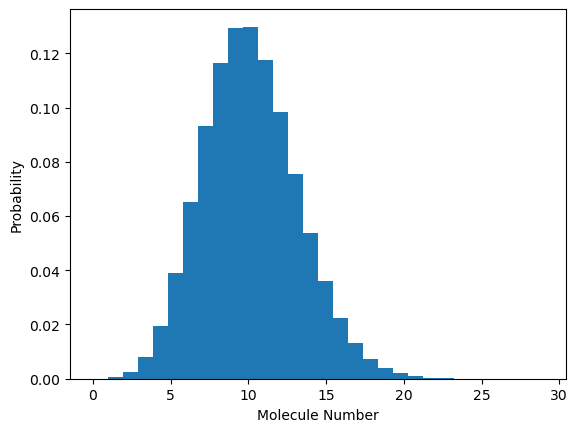

In [7]:
# Set the parameters
k = 10
r = 1
initial_state = 0
final_time = 10
num_trials = 1000000

# Run the trials
final_states = get_final_states_from_many_birth_death_trials(num_trials, k, r, initial_state, final_time)

# Compute some statistics
print("Mean:", np.mean(final_states))
print("Variance:", np.var(final_states))

# To plot the probability, we need to determine the number of bins
sample_min = np.min(final_states)
sample_max = np.max(final_states)
number_of_bins = sample_max - sample_min + 1
plt.hist(final_states, bins=number_of_bins, density=True)
plt.xlabel("Molecule Number")
plt.ylabel("Probability");

As the simulations run for longer,  the distribution should approach a steady state distribution. However, you need to ensure that you have enough trajectories to ensure that you are accurately sampling the distribution. The steady state distribution for this is a Poisson distribution with mean and variance equal to k/r. How many trajectories do you need to run and for how long should they be run to start observing steady state behavior?

## Trajectory Ensembles
We will define some functions to facilitate parallelization:

In [8]:
def get_frame_times(final_time, time_between_snapshots):
    num_times = math.ceil(final_time/time_between_snapshots)
    frame_times = time_between_snapshots*np.arange(num_times)
    return frame_times

@njit
def get_trajectory_from_single_birth_death_trial(k, r, initial_state, final_time, time_between_snapshots):
    # Set the state and time 
    state = initial_state
    time = 0
    snapshot_counter = 0
    snapshot_time = snapshot_counter*time_between_snapshots
    num_times = math.ceil(final_time/time_between_snapshots)
    trajectory = np.empty(num_times, dtype=np.int32)
    # The contents of this loop are exactly the same as the first one we did.
    while time < final_time:
        # First, determine when the next reaction occurs and advance the time
        u = 1 - np.random.rand()
        rate_sum = k + r*state
        dt = -np.log(u)/rate_sum
        time += dt
        # Store the snapshots
        while time >= snapshot_time and snapshot_time <= final_time:
            trajectory[snapshot_counter] = state
            snapshot_counter += 1
            snapshot_time = snapshot_counter*time_between_snapshots
        # Identify the reaction and update the state
        if time <= final_time:
            rate_fraction = np.random.rand()*rate_sum
            # We order the reactions [birth, death] for no particular reason
            if rate_fraction <= k:
                # Perform a birth event
                state += 1
            else:
                # Perform a death event
                state -= 1
    # Return the state at the end
    return trajectory

@njit(parallel=True)
def get_trajectories_from_many_birth_death_trials(num_trials, k, r, initial_state, final_time, time_between_snapshots):
    # Create a container for our results
    num_times = math.ceil(final_time/time_between_snapshots)
    results = np.empty((num_trials, num_times), dtype=np.int32)
    # prange tells the computer to do a number of parallel jobs equal to the value of num_trials
    for i in prange(num_trials):
        # Run each simulation and stick it in the list
        single_result = get_trajectory_from_single_birth_death_trial(k, r, initial_state, final_time, time_between_snapshots)
        results[i] = single_result
    return results

With these, we will run Gillespie simulations:

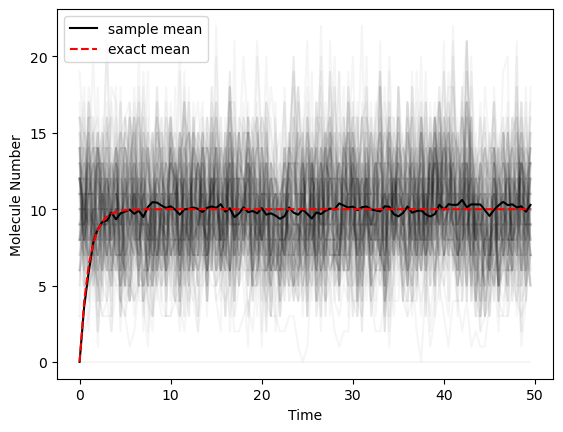

In [9]:
# Set the parameters
k = 10
r = 1
initial_state = 0
final_time = 50
num_trials = 100
time_between_snapshots = 0.5

# Get the times
times = get_frame_times(final_time, time_between_snapshots)

# Get the trajectories
trajectories = get_trajectories_from_many_birth_death_trials(num_trials, k, r, initial_state, final_time, time_between_snapshots)

# Plot the trajectories
# The alpha parameter ranges from 0 to 1, with 0 being completely transparent and 1 being completely opaque
# As the number of trajectories changes, you may need to tune the alpha parameter
plt.plot(times, trajectories,color='k', alpha=4.0/num_trials)
# Compute and plot the mean
average_trajectory = np.mean(trajectories,0)
mean_plot, = plt.plot(times, average_trajectory, color='k', label='sample mean')
# Exact mean
exact_mean_trajectory = (k/r)*(1.0 - np.exp(-r*times))
exact_plot, = plt.plot(times, exact_mean_trajectory, color='r', label='exact mean', linestyle='--')

# Label axes and display
plt.xlabel("Time")
plt.ylabel("Molecule Number")
plt.legend(handles=[mean_plot, exact_plot])
plt.show()

# A More Flexible Approach

## Defining the Reaction Class
We could write a unique code loop for each set of reactions, but that gets tedious quickly. All we really need to know from a reaction or event type is the rate it occurs at, given the state of the system, and how it changes the state of the system when it occurs. I provide a class that takes a NumPy array specifying the increment/ change to the state and a function that simplifies implementing the algorithm.

In [10]:
class Reaction:
    def __init__(self, increment, propensity_function):
        # This is the constructor. It just sets the internal variables.
        self.increment = increment
        self.propensity_function = propensity_function
    
    def get_propensity(self, state):
        # Gives the propensity. Called with rxn.get_propensity(state)
        return self.propensity_function(state)
    
    def update_state(self, state):
        # Applies the increment to the state. Called with rxn.update_state(state)
        state += self.increment

## Sampling Waiting Times
In the first part of the Gillespie algorithm, we need to sample waiting times. We find the sum of the rates, or the probability per unit time that _some_ event happens. We then divide the negative logarithm of a uniform random variable by this sum and return the result.

In [11]:
# Function that facilitates sampling the waiting times
def get_waiting_time(reaction_list, state):
    # Sum the propensities
    rate_sum = 0  
    for rxn in reaction_list:
        rate_sum += rxn.get_propensity(state)
    # Sample the waiting time
    u = 1 - np.random.rand()
    return -np.log(u)/rate_sum

## Determining Which Event Occurs Next
Next, we need to determine which kind of event occurs next. We sample a uniform random number and multiply it against the sum of propensities. We call this the "propensity fraction." Given an ordering of the reactions, we determine which reaction occurs by finding the smallest index such that the sum of those propensities exceeds the propensity fraction. Then we apply the increment for that reaction/ event.

In [12]:
def get_reaction_index_and_update_state(reaction_list, state):
    # Get the propensity fraction, the sum of propensities times a uniform random variable in (0, 1)
    u = np.random.rand()
    size = len(reaction_list)
    rates = np.full(size, 0)
    for i in np.arange(0, size):
        rates[i] = reaction_list[i].get_propensity(state)
    propensity_fraction = u*np.sum(rates)
    # Find the smallest partial sum or propensities that exceeds the propensity fraction
    rate_sum = 0
    rxn_index = 0
    for i in np.arange(size):
        rate_sum += rates[i]
        if propensity_fraction < rate_sum:
            rxn_index = i
            break
    # Apply the increment to the state for that reaction
    reaction_list[rxn_index].update_state(state)

These functions will make it much easier to implement arbitrary reaction schemes. However, this uses dynamic functions, particularly the get_propensity function, so it can't be compiled with Numba's njit for the speedup. When performance matters, the approach we did before is better.

## Helpful Functions for Plotting Trajectories

In [13]:
def get_frame_times(final_time, time_between_snapshots):
    num_times = math.ceil(final_time/time_between_snapshots)
    frame_times = time_between_snapshots*np.arange(num_times)
    return frame_times

def get_trajectory_container(final_time, time_between_snapshots, state):
    num_times = math.ceil(final_time/time_between_snapshots)
    empty_trajectory = np.empty((num_times, len(state)), dtype=np.int32)
    return empty_trajectory

def record_state(trajectory, state, time, snapshot_counter, final_time, time_between_snapshots):
    snapshot_time = snapshot_counter*time_between_snapshots
    while time >= snapshot_time and snapshot_time < final_time:
        trajectory[snapshot_counter] = state.copy()
        snapshot_counter += 1
        snapshot_time = snapshot_counter*time_between_snapshots
    return snapshot_counter

## Generalizing to Multiple Reacting Species
The class and functions are compatible with NumPy arrays. This means it can apply to a system with any number of reacting species. You just use a multi-dimensional array, with each component tracking a specific species. I illustrate this with an example of two de-coupled simple birth-death processes. First, we define the relevant Reaction objects:

In [14]:
# Birth for species 1
k1 = 10
def sbd_2_species_birth_1_rate(state):
    return k1

sbd_2_species_birth_1_inc = np.array([1, 0], dtype=np.int32)
sbd_2_species_birth_1 = Reaction(sbd_2_species_birth_1_inc, sbd_2_species_birth_1_rate)

# Birth for species 2
k2 = 1
def sbd_2_species_birth_2_rate(state):
    return k2

sbd_2_species_birth_2_inc = np.array([0, 1], dtype=np.int32)
sbd_2_species_birth_2 = Reaction(sbd_2_species_birth_2_inc, sbd_2_species_birth_2_rate)

# Death for species 1
r1 = 1
def sbd_2_species_death_1_rate(state):
    return r1*state[0]

sbd_2_species_death_1_inc = np.array([-1, 0], dtype=np.int32)
sbd_2_species_death_1 = Reaction(sbd_2_species_death_1_inc, sbd_2_species_death_1_rate)

# Death for species 2
r2 = 3
def sbd_2_species_death_2_rate(state):
    return r2*state[1]

sbd_2_species_death_2_inc = np.array([0, -1], dtype=np.int32)
sbd_2_species_death_2 = Reaction(sbd_2_species_death_2_inc, sbd_2_species_death_2_rate)

# Stick all the Reactions in a list
sbd_2_species_rxns = [sbd_2_species_birth_1, sbd_2_species_birth_2, sbd_2_species_death_1, sbd_2_species_death_2]

Then we can run Gillespie simulations:

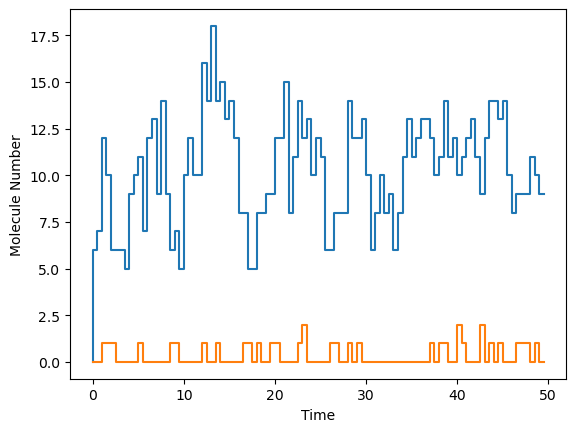

In [15]:
# Reset the initial state and time info
sbd_2_species_state = np.array([0,0])
time = 0
final_time = 50

# Set the variables pertaining to recording states
time_between_snapshots = 0.5
snapshot_counter = 0
times = get_frame_times(final_time, time_between_snapshots)
trajectory = get_trajectory_container(final_time, time_between_snapshots, sbd_2_species_state)

# Run the Gillespie simulation
while time < final_time:
    dt = get_waiting_time(sbd_2_species_rxns, sbd_2_species_state)
    time += dt
    snapshot_counter = record_state(trajectory, sbd_2_species_state, time, snapshot_counter, final_time, time_between_snapshots)
    get_reaction_index_and_update_state(sbd_2_species_rxns, sbd_2_species_state)
    
# Plot the trajectory
plt.step(times, trajectory)
plt.xlabel("Time")
plt.ylabel("Molecule Number");

# Extinction and Temporal Statistics

Consider the following systems of reactions: <br><br>
Production: $ X \rightarrow X + 1 $ with rate $$ \frac{k X}{X+c} $$  

Degradation: $ X \rightarrow X - 1 $ with rate $$ rX $$   

This kind of production rate appears in biochemistry in enzyme kinetics. It is known as Michaelis-Menten kinetics. Here it is promoting its own synthesis.

Before adding noise, let's think about how we expect the system to behave in a deterministic, continuous rate equation model. When k is very small, degradation dominates and we expect there to be molecules. Only when k is sufficiently large do we expect molecules to survive.

## Deterministic Behavior

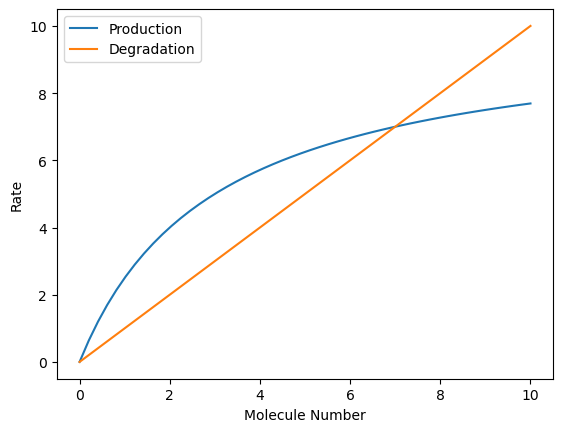

In [16]:
n_array = np.linspace(0.0, 10.0, 50)

k = 10
c = 3
production_array = k*np.divide(n_array, n_array + c)

r = 1
degradation_array = r*n_array

plt.plot(n_array, production_array)
plt.plot(n_array, degradation_array)
plt.legend(["Production", "Degradation"])
plt.xlabel("Molecule Number")
plt.ylabel("Rate");

## Stochastic Behavior
There's a problem when we add noise. The molecule count will eventually hit zero with a small, non-zero probability. Once it hits that state, there's no coming back. The probability of any reaction happening hits zero, no matter how high the production rate! We will study how long it takes the molecules to go "extinct."

### Create the Reaction Objects

In [17]:
# Birth: This creates a molecule at a rate that doesn't depend on the molecule number
k = 10
c = 3
def mm_birth_propensity(state):
    return k*state[0]/(c + state[0])

mm_birth_increment = np.array([1], dtype=np.int32)
mm_birth_rxn = Reaction(mm_birth_increment, mm_birth_propensity)

# Death: This degrades a molecule. Each molecule has a rate to decay, so it is proportional to the number.
r = 1
def mm_death_propensity(state):
    return r*state[0]

mm_death_increment = np.array([-1], dtype=np.int32)
mm_death_rxn = Reaction(mm_death_increment, mm_death_propensity)

# Reaction List
mm_rxn_list = [mm_birth_rxn, mm_death_rxn]

### Statistics for Extinction Times

Mean: 25.061878950369596
Standard deviation: 22.796848350435766


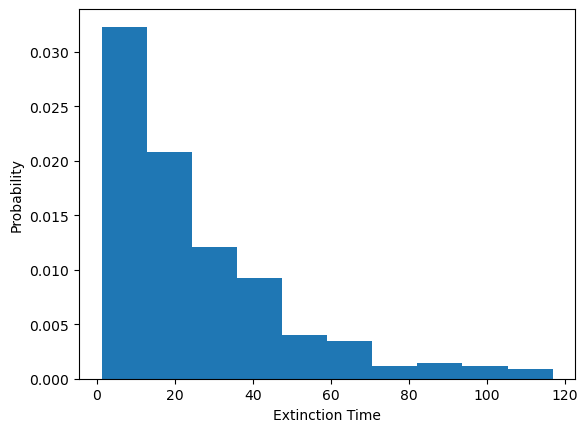

In [18]:
# Specify the simulation time and the number of trials
number_of_trials = 300
initial_number = 10

# Run all of the Gillespie Simulations
extinction_times = np.array([])
for trial in np.arange(number_of_trials):
    # Reset the time and state
    time = 0
    mm_state = np.array([initial_number], dtype=np.int32)
    # Run a Gillespie Simulation
    while mm_state[0] > 0:
        dt = get_waiting_time(mm_rxn_list, mm_state)
        time += dt
        get_reaction_index_and_update_state(mm_rxn_list, mm_state)
    # Save the extinction time and go to the next trial
    extinction_times = np.append(extinction_times, time)

# Compute some statistics
print("Mean:", np.mean(extinction_times))
print("Standard deviation:", np.std(extinction_times))

# To plot the probability, we need to determine the number of bins
plt.hist(extinction_times, density=True)
plt.xlabel("Extinction Time")
plt.ylabel("Probability");

# Exercises
Now, it is your turn. Here is a small collection of scenarios that can be studied using the methods developed here. Feel free to try any number of these or come up with your own ideas.

By measuring time in units of the timescales of one of the reactions, we can simplify studying models by eliminating one of the variables to explore.

## Option 1. Biochemistry and Systems Biology: The Toggle Switch and Stochastic Transitions

The toggle switch emerged as one of the simplest systems exhibiting decision-making capabilities. The idea is simple. You have two molecular species that try to inhibit the synthesis of the other. We will consider a greatly simplified version of the system with the reactions:  
Production 1: $(X, Y)\rightarrow (X+1,Y)$ with rate $$ \frac{k}{1 + (Y/c)^H} $$
Production 2: $(X, Y)\rightarrow (X,Y+1)$ with rate $$ \frac{k}{1 + (X/c)^H} $$  
Degradation 1: $(X, Y)\rightarrow (X-1,Y)$ with rate $$ X $$
Degradation 2: $(X, Y)\rightarrow (X,Y-1)$ with rate $$ Y $$
The parameters k, c, and H should be positive. The Hill coefficient H in the denominator arises from an effect called cooperativity: the binding of one molecule to DNA can make it easier for other molecules to bind to DNA, giving rise to feedback. Here are some questions:  
1. Start your system in an initial state with X = Y. Run a bunch of trajectories and look at the final states. To start, consider H = 2, c = 5, and k = 20. What does the distribution of states look like? Does this make sense?
2. The deterministic version of this is often used for cell fate decisions (for example, taking on tissue-specific roles). Initialize the system with Y = 0 and X comparable to k. How do long trajectories behave?
3. Run more simulations again with Y = 0 and X comparable to k. Define the switching time to be the time when Y > X. What does the switching time distribution look like? How does its average depend on the parameters? A suggestion: the system is fairly sensitive to changes in the parameters. Try small changes. This tells you that such binary decisions can switch stochastically, at least until other mechanisms kick in. This also suggests some strategies for pushing the switching time so far back as to be irrelevant to the cell.

## Option 2. Operations and Queues: Server Load

Suppose that you have $N$ servers or points of contact that are able to handle requests. Requests come in and are able to be processed at constant rates. For simplicity, assume that requests that are unable to be processed are turned away and must come back again. This leads to the process:  
Accepting a request: $M \rightarrow M + 1$ with rate 
$$ a \text{ if }M < N \quad \text{ or } \quad 0 \text{ when } M = N $$
Finishing a request: $M \rightarrow M - 1$ with rate $$ M $$

Questions:
1. How many servers are used on average?
2. How sensitive is the system? You can imagine the rate requests arrive at could depend on the time of day.
3. What is the probability that a request is turned away? This involves modifying the rates/ reactions. You need to track the number of accepted and rejected requests.

## Option 3. Population Genetics/ Dynamics: The Moran Model

Suppose that you have an environment, like an ecological niche, that can support a fixed number of N individuals. A mutation emerges in a subpopulation. We will treat replacement within the population as random. At some given rate, one individual is removed at random and replaced by another who has a copy of a gene from a random surviving individual. We start by considering the case where the mutation conveys no advantage or disadvantage to surviving and creating offspring. There are the following transitions and rates:  
Mutant expansion: $M \rightarrow M +1$ with rate $$ \frac{M(N-M)}{N^2} $$
Mutant removal: $M \rightarrow M -1$ with rate $$ \frac{M(N-M)}{N^2} $$  
Some questions:  
1. How does the mean number of mutants change in time? How does this depend on the initial number of mutants and the population size?
2. What are the ultimate fates of the system? What does the steady state distribution look like? What is the probability the mutation takes over the population or goes extinct? How does this depend on the initial number and population size?
3. Get some trajectories for the case where one mutant overtakes the population. Are there qualitative differences in the trajectories early on vs later?